In [ ]:
import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors
import scipy.stats as stats
from scipy.stats import norm
import seaborn as sns
import math

# Neuer Abschnitt

In [ ]:
%%bash

which git

/usr/bin/git


In [ ]:
pip install 'https://github.com/victorlei/smop.git'

     / 228 kB 24.4 MB/s
  ERROR: Cannot unpack file /tmp/pip-unpack-j1rpg5se/smop.git (downloaded from /tmp/pip-req-build-dahhephu, content-type: text/html; charset=utf-8); cannot detect archive format
ERROR: Cannot determine archive format of /tmp/pip-req-build-dahhephu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


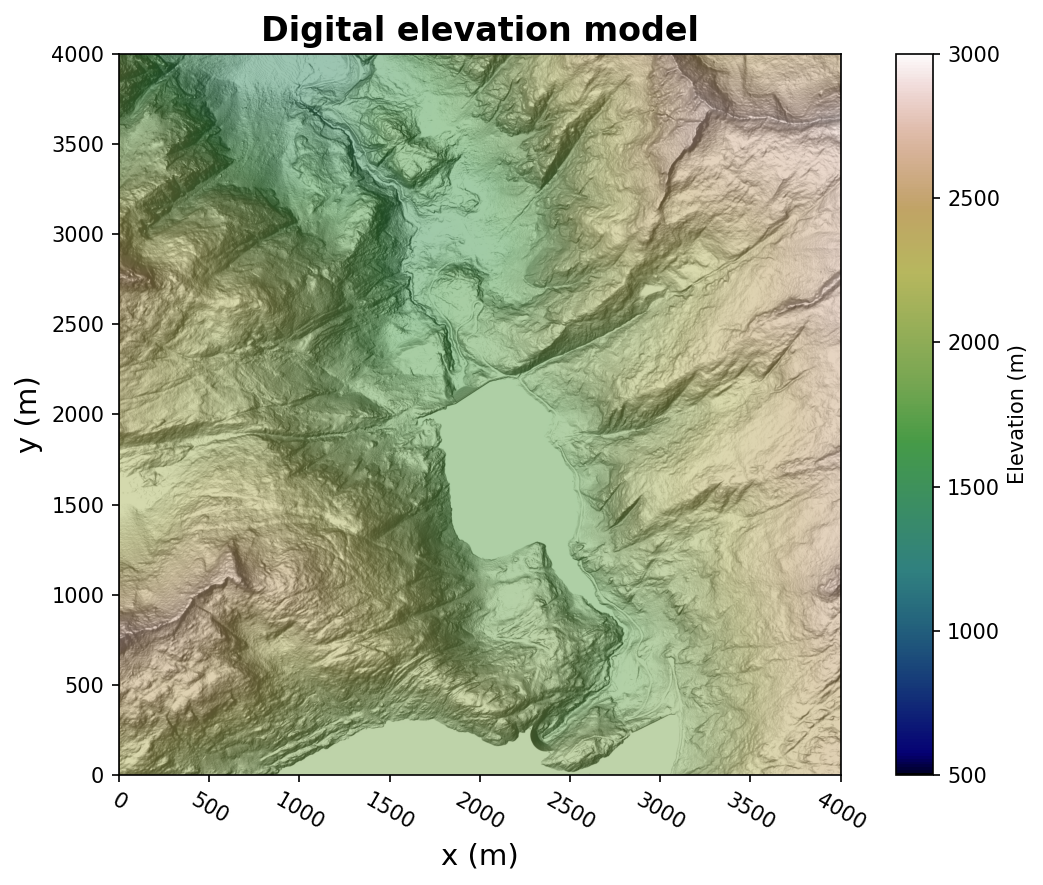

In [ ]:
# load all csv tables as individual data frames
# coordinates indicate 2m increments (e.g., 2 = 4m) and refer to the Swiss Coordinate system CH1903+ in the range
# LL:666000/158100  UR:670000/ 162100. 
# --> numbers in the CV titles refer to azimuthal illumination angle of hill shades; omni is the multi-directional hillshade

df_list=[]
path = "/content/drive/MyDrive/CSV_tables/"
name = "_HoughTest.csv"
index=['origi','55','99','1515']
for df_ in index:
    df_i = pd.read_csv("{}{}{}".format(path,df_,name),delimiter=';')
    df_list.append(df_i)
    
# Digital elevation model (dem)
url    = '/content/drive/MyDrive/CSV_tables/dem.csv' #read dem
dem    = pd.read_csv(url,header=None)
df_dem = pd.DataFrame(dem)
cmap   = 'gist_earth'

# omnidirectional hillshade
# cmap = sns.color_palette("Spectral_r", as_cmap=True)
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')

x, y     =  np.linspace(0,4000,2), np.linspace(0,4000,2)
xv, yv   =  np.meshgrid(x, y)

image = mpimg.imread('/content/drive/MyDrive/Pictures_input/HillSha2m_omni.jpg')

phys_coords = [0,4000,0,4000]

plt.imshow(image,extent=phys_coords)
plt.imshow(df_dem,alpha=.5,cmap=cmap,extent=phys_coords)
plt.clim(500, 3000)

# colorbar
cbar = plt.colorbar(label='Elevation (m)')
cbar.set_alpha(1)
cbar.draw_all()
# labbels
plt.xlabel('x (m)',size=14)
plt.ylabel('y (m)',size=14)
plt.xticks(np.arange(0, 4000+1, step=500),rotation='-30')
plt.yticks(np.arange(0, 4000+1, step=500),rotation='  0')
plt.title('Digital elevation model',size=16,fontweight="bold")

plt.tight_layout()

#plt.savefig("fig_DEM.png", dpi=300)

In [ ]:
# get lengths of individual data frames
length_list=[]
for df in df_list:
    len_i = len(df)
    length_list.append(len_i)

# get positions for splitting 
split_pos   = np.zeros(5)  
split_pos[1::] = np.cumsum(length_list)
split_pos = split_pos.astype(int)
#print('df lengths:',length_list,'df cumsum:',split_pos)

In [ ]:
# put all frames together
df_tot = pd.concat(df_list, axis=0)
#print('merged df:',df_tot.shape)

In [ ]:
df_tot.head(5)

,x start,y start,x end,y end
0,213,1156,330,1114
1,1618,1073,1847,535
2,200,1,555,321
3,815,89,824,4
4,1448,1010,1625,1125


In [ ]:
# Calculate 2D properties (pixel domain)

# 2D mid point coordinates
df_tot['x mid'] = (df_tot['x start'] + df_tot['x end'])/2
df_tot['y mid'] = (df_tot['y start'] + df_tot['y end'])/2

# 2D euclidean distance
df_tot['2D segment length'] = round(np.sqrt((df_tot['x end']-df_tot['x start'])**2 +
                                            (df_tot['y end']-df_tot['y start'])**2),2)

# scale 2D properties to physical dimensions (i.e. in m) for length calculations

# cell size [m]
scale_fac = 2

df_tot['x start phys'] = scale_fac*df_tot['x start']
df_tot['y start phys'] = np.absolute(scale_fac*df_tot['y start'] -4000)
df_tot['x end phys']   = scale_fac*df_tot['x end']
df_tot['y end phys']   = np.absolute(scale_fac*df_tot['y end'] -4000)

# 2D mid point coordinates
df_tot['x mid phys'] = (df_tot['x start phys'] + df_tot['x end phys'])/2
df_tot['y mid phys'] = (df_tot['y start phys'] + df_tot['y end phys'])/2

# 2D euclidean distance
df_tot['2D segment length phys'] = round(np.sqrt((df_tot['x end phys']-df_tot['x start phys'])**2 +
                                            (df_tot['y end phys']-df_tot['y start phys'])**2),2)

# Fault strike orientation
df_tot['fault strike']   = abs(round(np.rad2deg(np.arctan((df_tot['y end']-df_tot['y start'])/
                                                      (df_tot['x end']-df_tot['x start'])))+90,2)-180)

df_tot.head(10)

,x start,y start,x end,y end,x mid,y mid,2D segment length,x start phys,y start phys,x end phys,y end phys,x mid phys,y mid phys,2D segment length phys,fault strike
0,213,1156,330,1114,271.5,1135.0,124.31,426,1688,660,1772,543.0,1730.0,248.62,109.75
1,1618,1073,1847,535,1732.5,804.0,584.71,3236,1854,3694,2930,3465.0,2392.0,1169.42,156.94
2,200,1,555,321,377.5,161.0,477.94,400,3998,1110,3358,755.0,3678.0,955.88,47.97
3,815,89,824,4,819.5,46.5,85.48,1630,3822,1648,3992,1639.0,3907.0,170.95,173.96
4,1448,1010,1625,1125,1536.5,1067.5,211.08,2896,1980,3250,1750,3073.0,1865.0,422.16,56.99
5,1866,1018,1998,1150,1932.0,1084.0,186.68,3732,1964,3996,1700,3864.0,1832.0,373.35,45.00
6,1661,168,1874,122,1767.5,145.0,217.91,3322,3664,3748,3756,3535.0,3710.0,435.82,102.19
7,258,1817,483,1496,370.5,1656.5,392.00,516,366,966,1008,741.0,687.0,784.01,144.97
8,27,2,915,695,471.0,348.5,1126.41,54,3996,1830,2610,942.0,3303.0,2252.81,52.03
9,1513,1269,1998,1827,1755.5,1548.0,739.32,3026,1462,3996,346,3511.0,904.0,1478.63,41.00


In [ ]:
# Calculate 3D properties

# x and y needed switching for the lookup, due to the difference in geograph. and math. coordinates?
df_tot['z start phys'] = df_dem.lookup(df_tot['y start'].astype('int'),df_tot['x start'].astype('int'))
df_tot['z end phys']   = df_dem.lookup(df_tot['y end'].astype('int'),df_tot['x end'].astype('int'))
df_tot['z mid phys']   = df_dem.lookup(round(df_tot['y mid'].astype('int')-.5,0),round(df_tot['x mid'].astype('int')-.5,0))

# 3D euclidean distance
df_tot['3D segment length phys'] = round(np.sqrt((df_tot['x end phys']-df_tot['x start phys'])**2 +
                                            (df_tot['y end phys']-df_tot['y start phys'])**2 +
                                            (df_tot['z end phys']-df_tot['z start phys'])**2),2)

# Get max and min values
column = df_tot["z mid phys"]
max_z  = 100*math.ceil(column.max()/100)
min_z  = 100*math.floor(column.min()/100)

df_tot.head(10)

,x start,y start,x end,y end,x mid,y mid,2D segment length,x start phys,y start phys,x end phys,y end phys,x mid phys,y mid phys,2D segment length phys,fault strike,z start phys,z end phys,z mid phys,3D segment length phys
0,213,1156,330,1114,271.5,1135.0,124.31,426,1688,660,1772,543.0,1730.0,248.62,109.75,2180,2177,2193,248.64
1,1618,1073,1847,535,1732.5,804.0,584.71,3236,1854,3694,2930,3465.0,2392.0,1169.42,156.94,2243,2514,2432,1200.41
2,200,1,555,321,377.5,161.0,477.94,400,3998,1110,3358,755.0,3678.0,955.88,47.97,1504,1596,1490,960.29
3,815,89,824,4,819.5,46.5,85.48,1630,3822,1648,3992,1639.0,3907.0,170.95,173.96,1619,1672,1631,178.98
4,1448,1010,1625,1125,1536.5,1067.5,211.08,2896,1980,3250,1750,3073.0,1865.0,422.16,56.99,2046,2281,2111,483.16
5,1866,1018,1998,1150,1932.0,1084.0,186.68,3732,1964,3996,1700,3864.0,1832.0,373.35,45.00,2454,2612,2526,405.41
6,1661,168,1874,122,1767.5,145.0,217.91,3322,3664,3748,3756,3535.0,3710.0,435.82,102.19,2726,2617,2662,449.24
7,258,1817,483,1496,370.5,1656.5,392.00,516,366,966,1008,741.0,687.0,784.01,144.97,2351,2460,2305,791.55
8,27,2,915,695,471.0,348.5,1126.41,54,3996,1830,2610,942.0,3303.0,2252.81,52.03,1791,1675,1595,2255.80
9,1513,1269,1998,1827,1755.5,1548.0,739.32,3026,1462,3996,346,3511.0,904.0,1478.63,41.00,2181,2432,2291,1499.79


In [ ]:
#slice merged df_tot and store in df list 
#savind df to extended DB  

df_index=['origi','55','99','1515']
df_list2=[]
len_list=[]
for i in range(0,len(df_index),1):
        df_i= df_tot.iloc[split_pos[i]:split_pos[(i+1)],:]
        df_list2.append(df_i)
        df_i.to_csv(df_index[i],index=False)
              
for i in range(0,len(df_index),1):
        len_i = len(df_list2[i])
        len_list.append(len_i)

In [ ]:
for i in range(0,len(df_index),1):
    print(len_list[i],'entries for',df_index[i])

31733 entries for origi
50764 entries for 55
31510 entries for 99
4856 entries for 1515


In [ ]:
df_list20=df_list2[0]
df_list20=df_list2[0]
df_list20=df_list2[0]
df_list20.head(5)
df_list20.shape

(31733, 19)

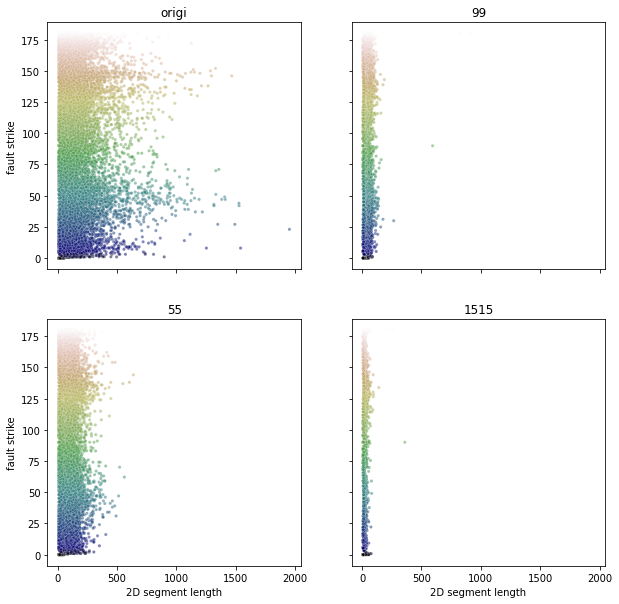

In [ ]:
#fig, ax = plt.subplots(2,2,figsize=(15, 20))
f_vis1, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True, facecolor='w', edgecolor='k')
degree = ''
i=0
for j in range(0,2,1):
    for k in range(0,2,1):
        if i == 7:
          g=sns.scatterplot(data=df_list2[i],x = '2D segment length',y = 'fault strike',s=1)
          #sns.histplot(data=df_list2[i],x='fault strike',bins=20)
          axes[k,j].set_title("{}{}".format(index[i],degree))
          axes[k,j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
          #axes[k,j].set_ylim=(1,150) -> does not work
        else:
            sns.scatterplot(data = df_list2[i], x = '2D segment length', y= 'fault strike', hue = 'fault strike',
                            legend=False, palette=cmap, ax=axes[k,j], size=1,
                            sizes=(10,500), alpha=0.5)
            axes[k,j].set_title("{}{}".format(index[i],degree))
            
            
        i=i+1
#df_tot['2D segment length']


In [ ]:
degree = '$^{\circ}$'
print(degree)

$^{\circ}$


Text(0.05, 0.5, 'Y (m)')

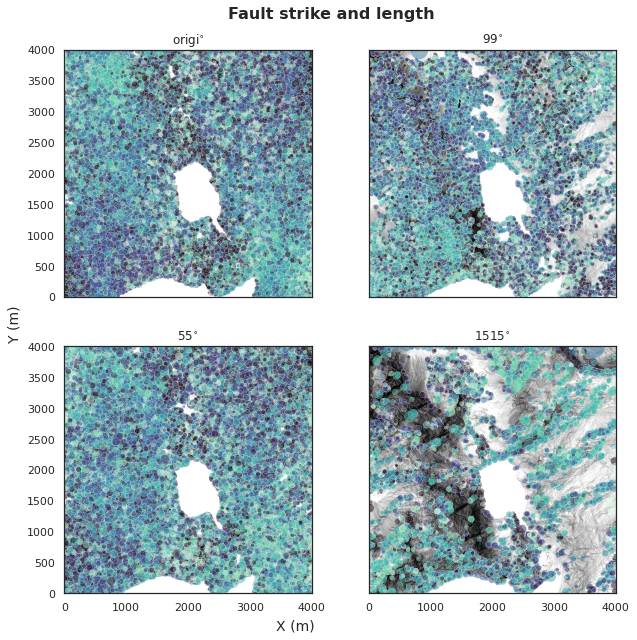

In [ ]:
# Orientation & Lengths
# Attribute comparison - as mid points
sns.set(style="white", palette="muted", color_codes=True)
cmap ="mako"
mkrsize = 5
alpha_val = 0.5
degree = '$^{\circ}$'
f_vis1, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True, facecolor='w', edgecolor='k')

# plot mid points
i=0
for j in range(0,2,1):
    for k in range(0,2,1):
        if i == 5:
            sns.scatterplot(data = df_list2[i], x = 'x mid phys', y= 'y mid phys', hue = 'fault strike', 
                            legend="brief", palette=cmap, ax=axes[k,j], size='3D segment length phys',
                            sizes=(10,500), alpha=alpha_val)
            axes[k,j].set_title("{}{}".format(index[i],degree))
            axes[k,j].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            axes[k,j].imshow(image,extent=phys_coords) 
        else:
            sns.scatterplot(data = df_list2[i], x = 'x mid phys', y= 'y mid phys', hue = 'fault strike',
                            legend=False, palette=cmap, ax=axes[k,j], size='3D segment length phys',
                            sizes=(10,500), alpha=alpha_val)
            axes[k,j].set_title("{}{}".format(index[i],degree))
            axes[k,j].imshow(image,extent=phys_coords)
        i=i+1
        
# make title and subtitles
f_vis1.suptitle('Fault strike and length', y=0.94, fontsize=16, fontweight='bold')  
plt.setp(axes, xlabel='', ylabel='')
f_vis1.text(0.45, 0.08, 'X (m)', ha='center', va='center', fontsize=14)
f_vis1.text(0.05, 0.5 , 'Y (m)', ha='left'  , va='center', fontsize=14, rotation='vertical')
#plt.savefig("fig_fault_strike_and_length.png", dpi=300)

Text(0.05, 0.5, 'Y (m)')

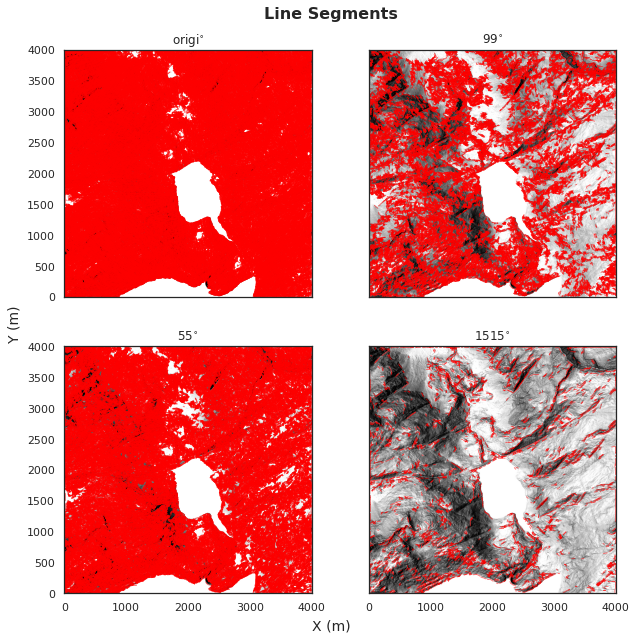

In [ ]:
# line check - slow due number of lines

f_lines, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True, facecolor='w', edgecolor='k')
segm_width = 1
alpha_val  = .5
i=0
for j in range(0,2,1):
    for k in range(0,2,1):
        axes[k,j].plot((df_list2[i]['x start phys'],df_list2[i]['x end phys']),
                       (df_list2[i]['y start phys'],df_list2[i]['y end phys']),
                        color='red',alpha=alpha_val,linewidth=segm_width)
        axes[k,j].set_title("{}{}".format(index[i],degree))
        axes[k,j].imshow(image,extent=phys_coords)
        i=i+1
        
# make title and subtitles
f_lines.suptitle('Line Segments', y=0.94, fontsize=16, fontweight='bold')
plt.setp(axes, xlabel='', ylabel='')
f_lines.text(0.5, 0.08, 'X (m)', ha='center', va='center', fontsize=14)
f_lines.text(0.05, 0.5, 'Y (m)', ha='left'  , va='center', fontsize=14, rotation='vertical')

#plt.savefig("fig_Calculated_line_segments.png", dpi=300)

In [ ]:
# Attribute comparision - in data dimensions
# absolute key values for orientation
r_index=['mean_or','med_or','std_or','mean_2D_length','med_2D_length','std_2D_length','mean_3D_length','med_3D_length','std_3D_length']
Res_stat=np.zeros((len(r_index),len(index)))
k=0                                                            
for df in df_list2:                                                 
    Res_stat[0,k]=round(df['fault strike'].mean(),1)
    Res_stat[1,k]=round(df['fault strike'].median(),1)
    Res_stat[2,k]=round(df['fault strike'].std(),1)
    Res_stat[3,k]=round(df['2D segment length phys'].mean(),1)
    Res_stat[4,k]=round(df['2D segment length phys'].median(),1)
    Res_stat[5,k]=round(df['2D segment length phys'].std(),1)
    Res_stat[6,k]=round(df['3D segment length phys'].mean(),1)
    Res_stat[7,k]=round(df['3D segment length phys'].median(),1)
    Res_stat[8,k]=round(df['3D segment length phys'].std(),1)
    k=k+1
#print(Res_stat)
df_stats = pd.DataFrame(Res_stat, columns=index, index=r_index)
df_stats

,origi,55,99,1515
mean_or,87.6,92.1,90.7,99.8
med_or,88.2,93.0,90.0,110.6
std_or,52.8,51.1,53.0,50.3
mean_2D_length,204.2,89.3,47.3,37.5
med_2D_length,122.4,62.6,38.0,30.5
std_2D_length,252.3,82.8,33.6,23.6
mean_3D_length,224.3,100.1,53.4,41.8
med_3D_length,136.3,70.9,43.0,34.7
std_3D_length,269.4,91.5,37.1,25.6


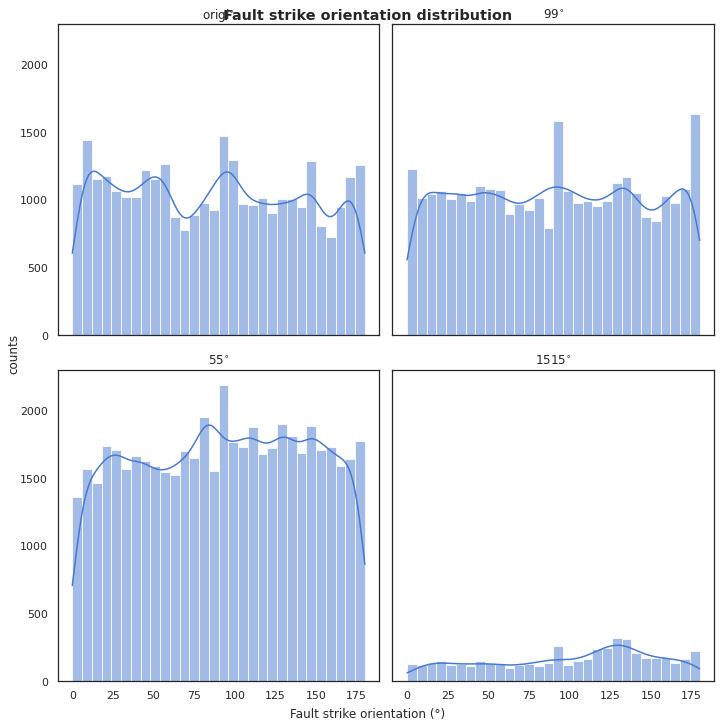

In [ ]:
#orientation histograms
#from sklearn.neighbors import KernelDensity
#for future: https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html
#could be useful for parameter estimation
x = np.linspace(0,180,180)
f_his1, axes = plt.subplots(2, 2, figsize=(10, 10),sharex=True, sharey=True)
i=0
for j in range(0,2,1):
    for k in range(0,2,1):
    #axes[k,j].plot(x, norm.pdf(x,df_stats.iloc[0,l],df_stats.iloc[2,l]),'b-', lw=2,)   #simple unimodal norm. pdf fit
        sns.histplot(df_list2[i]['fault strike'], kde=True,ax=axes[k,j],bins=30)
        axes[k,j].set_title("{}{}".format(index[i],degree))
        i=i+1
    
# make title and subtitles
f_his1.suptitle('Fault strike orientation distribution',fontsize='large',ha='center',fontweight='bold')
plt.setp(axes, xlabel='', ylabel='')
f_his1.text(0.5, 0.0, 'Fault strike orientation (°)', ha='center', va='center', fontsize=12)
f_his1.text(0.0, 0.5, 'counts', ha='left', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.savefig("fig_fault_strike_histograms.png", dpi=300)

Some statistics on Circular Data

In [ ]:
import cmath
import numpy as np
import scipy.stats as stats

# Circular mean of angle data(default to degree)
a = np.deg2rad(df_tot['fault strike'])
angles_complex = np.frompyfunc(cmath.exp, 1, 1)(a * 1j)
mean = cmath.phase(angles_complex.sum()) % (2 * np.pi)
print("Circular mean")
print(np.rad2deg(mean))

Circular mean
90.97605635713558


In [ ]:
# Circular variance of angle data(default to degree)
r =abs(angles_complex.sum()) / len(df_tot['fault strike'])
print("Circular Variance:")
print("1 - R=",1-r)
print("R=",r)

Circular Variance:
1 - R= 0.36468967646037853
R= 0.6353103235396215


In [ ]:
df_list2[0]

,x start,y start,x end,y end,x mid,y mid,2D segment length,x start phys,y start phys,x end phys,y end phys,x mid phys,y mid phys,2D segment length phys,fault strike,z start phys,z end phys,z mid phys,3D segment length phys
0,213,1156,330,1114,271.5,1135.0,124.31,426,1688,660,1772,543.0,1730.0,248.62,109.75,2180,2177,2193,248.64
1,1618,1073,1847,535,1732.5,804.0,584.71,3236,1854,3694,2930,3465.0,2392.0,1169.42,156.94,2243,2514,2432,1200.41
2,200,1,555,321,377.5,161.0,477.94,400,3998,1110,3358,755.0,3678.0,955.88,47.97,1504,1596,1490,960.29
3,815,89,824,4,819.5,46.5,85.48,1630,3822,1648,3992,1639.0,3907.0,170.95,173.96,1619,1672,1631,178.98
4,1448,1010,1625,1125,1536.5,1067.5,211.08,2896,1980,3250,1750,3073.0,1865.0,422.16,56.99,2046,2281,2111,483.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31728,458,1848,501,1823,479.5,1835.5,49.74,916,304,1002,354,959.0,329.0,99.48,120.17,2085,2061,2080,102.33
31729,37,305,91,262,64.0,283.5,69.03,74,3390,182,3476,128.0,3433.0,138.06,128.53,1957,1919,1938,143.19
31730,1971,1411,1987,1453,1979.0,1432.0,44.94,3942,1178,3974,1094,3958.0,1136.0,89.89,20.85,2591,2661,2622,113.93
31731,1598,261,1634,295,1616.0,278.0,49.52,3196,3478,3268,3410,3232.0,3444.0,99.04,46.64,2583,2551,2562,104.08


In [172]:
max(df_list2[0]['2D segment length'])

1951.35

In [ ]:
dir(df_list2[0]['2D segment length'])

In [ ]:
type(df_tot['fault strike'])

pandas.core.series.Series

In [ ]:
df_list2[]['x start phys']

Model 3

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.mixture import GaussianMixture

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from matplotlib import  pyplot as plt
import numpy as np
import pandas as pd
from imageio import imread
from time import time as timer
import os
import tarfile

import tensorflow as tf

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

from scipy.stats import entropy

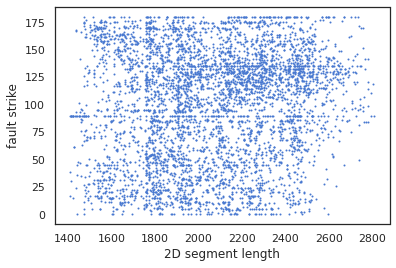

In [175]:
plt.plot(df_list2[3]['z start phys'],df_list2[3]['fault strike'],'o', markersize=1)
plt.xlabel('2D segment length')
plt.ylabel('fault strike')
plt.show()

In [186]:
clusterer = KMeans(n_clusters=2, random_state=10)
my_array1 =np.array(df_list2[3]['z start phys'])
#t_my_array1 =np.transpose(my_array1)
my_array2 =np.array(df_list2[3]['fault strike'])
#t_my_array2 =np.transpose(my_array2)
my_array3 = np.asarray([my_array1, my_array2])
print(my_array3.shape)

(2, 4856)


In [187]:
t_my_array3 = np.transpose(my_array3)
print(t_my_array3.shape)

(4856, 2)


In [155]:
#t_my_array3[:,0]

array([ 543., 3465.,  755., ..., 3958., 3232., 3745.])

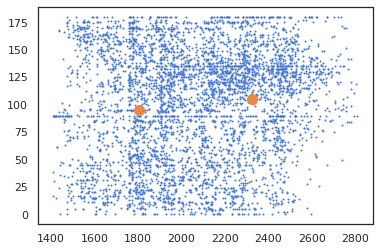

In [188]:
clusterer.fit(t_my_array3)
plt.plot(df_list2[3]['z start phys'],df_list2[3]['fault strike'],'o', markersize=1)
plt.plot(clusterer.cluster_centers_[:,0],clusterer.cluster_centers_[:,1],'o',markersize=10)
plt.show()

In [189]:
clusterer.cluster_centers_[:,:]

array([[2324.03776683,  104.77130542],
       [1804.01239669,   94.74826033]])

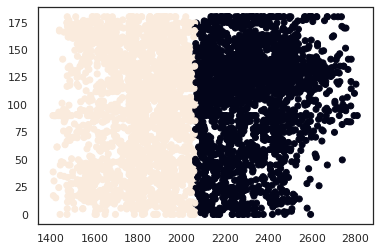

In [192]:
cluster_labels=clusterer.predict(t_my_array3)
plt.scatter(t_my_array3[:,0],t_my_array3[:,1],c=cluster_labels)
plt.show()

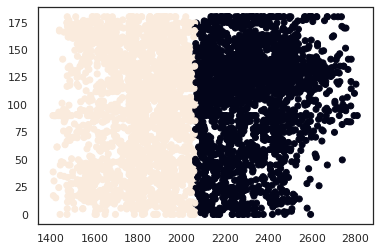

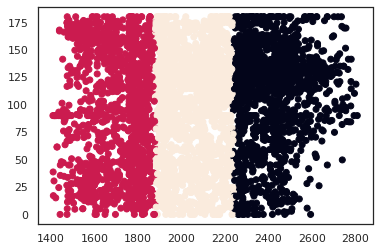

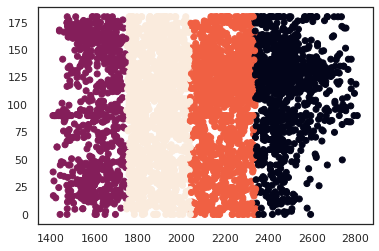

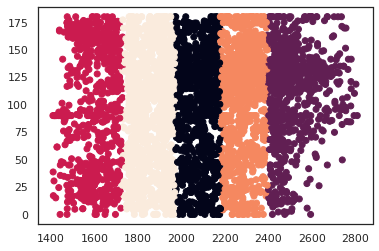

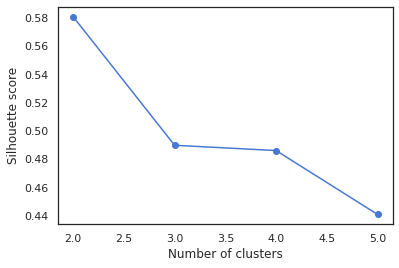

In [193]:
sil=[]

for iclust in range(2,6):
    clusterer = KMeans(n_clusters=iclust, random_state=10)
    cluster_labels = clusterer.fit_predict(t_my_array3)
    score=silhouette_score(t_my_array3,cluster_labels)
    sil.append(score)
    plt.scatter(t_my_array3[:,0],t_my_array3[:,1],c=cluster_labels)
    plt.show()
    
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.plot(np.arange(len(sil))+2, sil,'-o')
plt.show()

In [199]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster import hierarchy
from ipywidgets import interact
from scipy.cluster.hierarchy import fcluster

#points=km_load_th1()
Z = hierarchy.linkage(t_my_array3, 'single')
n_clusters=int(np.max(Z[:,[0,1]].flatten()))
print(n_clusters)

@interact
def plot(t=(0,17,0.1)):  
    fig, axes=plt.subplots(1,2,figsize=(15,10), gridspec_kw={'width_ratios': [1, 2]})
    fl = fcluster(Z,t=t,criterion='distance')
    maps={}
    for clust in range(n_clusters):
        maps[clust]=(fl==clust)
    c=0
    for clust in range(n_clusters):
        if np.sum(maps[clust])>0:
            c+=1
    plt.figure(figsize=(19,5))
    d = hierarchy.dendrogram(Z,ax=axes[1], color_threshold=t)
    axes[1].axhline(t,linestyle='--',color='red')
    axes[1].set_ylabel('Cluster distance')
    axes[1].axes.get_xaxis().set_visible(False)
    axes[1].set_xlabel('Points')
    axes[1].set_title(f'Number clusters: {c}')
    axes[0].scatter(t_my_array3[d['leaves'],0],t_my_array3[d['leaves'],1])

9709


interactive(children=(FloatSlider(value=8.0, description='t', max=17.0), Output()), _dom_classes=('widget-inte…

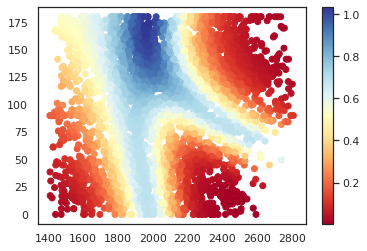

In [203]:
#In this exercise you need to load the dataset used to present K-means ( def km_load_th1() ) or the one used to discuss 
# the Gaussian mixtures model ( def gm_load_th1() ). 
#As discussed, applying a fitting based on gaussian mixtures you can not only predict the cluster label for each point, 
#but also a probability distribution over the clusters. 

#From this probability distribution, you can compute for each point the entropy of the corresponging 
#distribution (using for example scipy.stats.entropy) as an estimation of the undertainty of the prediction. 
#Your task is to plot the data-cloud with a color proportional to the uncertainty of the cluster assignement.

# In detail you shoud:
# 1. Instantiate a GaussianMixture object with the number of clusters that you expect
# 2. fit the object on the dataset with the fit method 

from scipy.stats import entropy
points=t_my_array3

plt.figure()
clf = GaussianMixture(n_components=3, covariance_type='full')

clf.fit(points)

# 3. compute the cluster probabilities using the method predict_proba. This will return a matrix of 
# dimension npoints x nclusters
# 4. use the entropy function ( from scipy.stats import entropy ) to evaluate for each point the uncertainty of the 
#prediction

cluster_labels_prob=clf.predict_proba(points)

entropies=[]
for point in range(len(cluster_labels_prob)):
    entropies.append(entropy(cluster_labels_prob[point]))

# 5. Plot the points colored accordingly to their uncertanty. 

cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(points[:,0], points[:,1], c=entropies, cmap=cm)
plt.colorbar(sc)
    